## Libraries and Imports

In [1]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "7"

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.metrics import (accuracy_score, f1_score, precision_score,
                             recall_score)
from sklearn.model_selection import train_test_split
from tqdm import tqdm

from llms.exin_classifier.dnabert import ExInClassifierDNABERT
from schemas.train_params import TrainParams

## Params and Files

In [3]:
seed = 12

csv_path = "exin-256.csv"
pretrained_model_name = "ExInDNABERT2"

In [4]:
csv_path = f"./storage/data/processed/{csv_path}"
output_path = f"./storage/models/tuned/{pretrained_model_name}"
checkpoint = f"./storage/models/base/dnabert2"

## Reading Dataset

In [5]:
df = pd.read_csv(csv_path, keep_default_na=False)

## Loading the Model

In [6]:
llm = ExInClassifierDNABERT(
 checkpoint=checkpoint, 
 seed=seed
)

/home-lib/gustavo.cruz/.cache/huggingface/modules/transformers_modules/dnabert2/bert_layers.py:126: UserWarning: Unable to import Triton; defaulting MosaicBERT attention implementation to pytorch (this will reduce throughput when using this model).
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at ./storage/models/base/dnabert2 and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Data Processing

In [7]:
data = df.to_dict(orient="records")

In [8]:
all_dataset = []
for record in tqdm(data):
	example = llm.build_input(
		sequence=record["sequence"],
		target=record.get("target")
	)
	all_dataset.append(example)

train_dataset, test_dataset = train_test_split(
	all_dataset,
	test_size=0.05,
	random_state=seed,
	shuffle=True
)

100%|██████████| 6600498/6600498 [00:02<00:00, 2476784.82it/s]


# Data Analysis

In [9]:
print("Train Dataset Len:", len(train_dataset))
print("Test Dataset Len:", len(test_dataset))

Train Dataset Len: 6270473
Test Dataset Len: 330025


In [10]:
train_lengths = [len(example["sequence"]) for example in train_dataset]
test_lengths = [len(example["sequence"]) for example in test_dataset]

Train Dataset Len: 6270473
Test Dataset Len: 330025


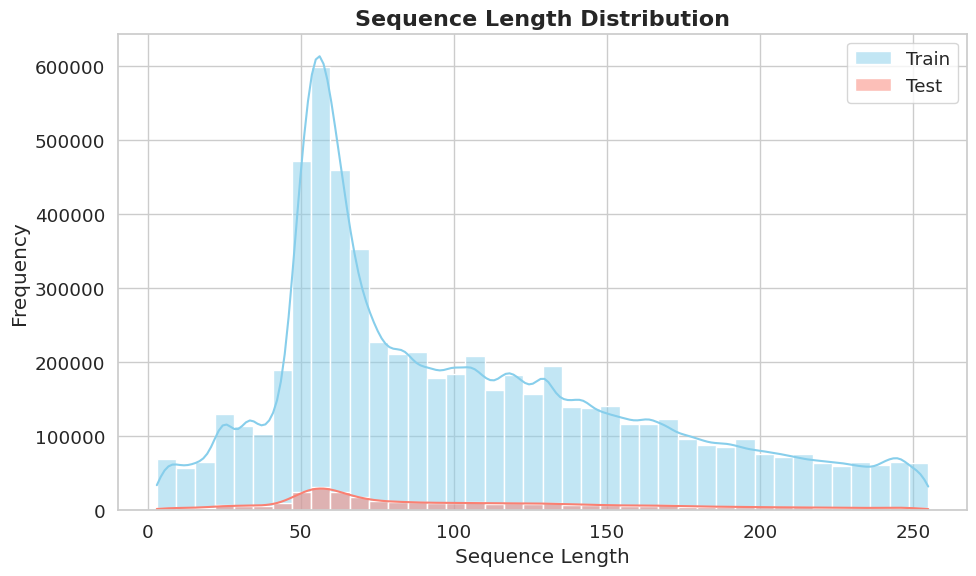

In [11]:
print("Train Dataset Len:", len(train_dataset))
print("Test Dataset Len:", len(test_dataset))

sns.set_theme(style="whitegrid", palette="muted", font_scale=1.2)

plt.figure(figsize=(10, 6))
sns.histplot(train_lengths, kde=True, bins=40, color="skyblue", label="Train")
sns.histplot(test_lengths, kde=True, bins=40, color="salmon", label="Test")

plt.title("Sequence Length Distribution", fontsize=16, weight="bold")
plt.xlabel("Sequence Length")
plt.ylabel("Frequency")
plt.legend()
plt.tight_layout()
plt.show()

# Training

In [11]:
llm.train(
  dataset=train_dataset,
  params=TrainParams(
    epochs=1,
    batch_size=128,
    gradient_accumulation=1,
    lr=1e-5,
    logging_steps=500
	)
)

2025-10-14 14:06:34,561 - INFO - Preparing dataset...
100%|██████████| 6270473/6270473 [07:51<00:00, 13288.46it/s]
2025-10-14 14:17:53,415 - INFO - Dataset prepared!
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
2025-10-14 14:18:02,911 - INFO - Starting training...


Step,Training Loss
500,0.131700
1000,0.041500
1500,0.033900
2000,0.030200
2500,0.027400
3000,0.027400
3500,0.025800
4000,0.025700
4500,0.025100
5000,0.024200


2025-10-14 15:51:52,724 - INFO - Training complete. You may save the model for later usage.


# Saving The Model

In [ ]:
llm.save_pretrained(output_path)

# Test

In [12]:
y_true = []
y_pred = []

for data in tqdm(test_dataset):
	answer = llm.generate(data)
	y_pred.append(answer)
	y_true.append(data["target"])

100%|██████████| 330025/330025 [58:31<00:00, 94.00it/s]  


In [13]:
print("INTRON class:")
print("  Precision :", precision_score(y_true, y_pred, pos_label="INTRON"))
print("  Recall    :", recall_score(y_true, y_pred, pos_label="INTRON"))
print("  F1        :", f1_score(y_true, y_pred, pos_label="INTRON"))
print()
print("EXON class:")
print("  Precision :", precision_score(y_true, y_pred, pos_label="EXON"))
print("  Recall    :", recall_score(y_true, y_pred, pos_label="EXON"))
print("  F1        :", f1_score(y_true, y_pred, pos_label="EXON"))
print()
print("  Accuracy  :", accuracy_score(y_true, y_pred))

INTRON class:
  Precision : 0.9943332991028502
  Recall    : 0.9922120991932629
  F1        : 0.9932715666571856

EXON class:
  Precision : 0.9962495738152063
  Recall    : 0.9972741030811167
  F1        : 0.9967615751806045

  Accuracy  : 0.9956276039693963
